In the end, we need, for every date that a currency return is observed on, the following information:
- number of days to the next policy meeting of 'own' central bank;
- number of days to the next policy meeting of FOMC;
- whether the next meeting is scheduled or surprize;
- the outcome of the meeting (hike, cut or no change).

# raw data
We collect announcement dates for a number of central banks (from their websites and twitter, manually and not):

- Australia, RBA;
- New Zealand, RNBZ;
- Norway, Norges bank;
- Sweden, Riksbank;
- Switzerland, SNB;
- Canada, BoC;
- United Kingdom, BoE;
- Eurozone, ECB;
- United States, FOMC.

This data in stored in `data/raw/policy-meetings-{BANK_NAME}.csv`. When loading it, we convert the times to the New York time zone (ET).

The quality of data is very high, but please still expect some mistakes, especially in the early years, for which the actual timing of press releases is unknown, and mistakes and contradictions on the regulators' websites are plenty.

In [16]:
import sys; sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

from config import *

from src.datafeed.downstream import (
    get_policy_rate_announcements,
    get_usd_exchange_rates,
    get_bank_to_currency_map
)

plt.style.use("seaborn-v0_8-colorblind")

In [17]:
pr = get_policy_rate_announcements()
pr.head(10).style.format(precision=2)

,bank,date_announcement,rate_change,is_scheduled
0,snb,2000-01-01 04:00:00-05:00,0.00,False
1,snb,2000-02-03 04:00:00-05:00,0.50,False
2,snb,2000-03-23 04:00:00-05:00,0.75,True
3,snb,2000-06-15 04:00:00-04:00,0.50,True
4,snb,2000-09-14 04:00:00-04:00,0.00,True
5,snb,2000-12-08 04:00:00-05:00,0.00,True
6,snb,2001-03-22 04:00:00-05:00,-0.25,True
7,snb,2001-06-14 04:00:00-04:00,0.00,True
8,snb,2001-09-17 04:00:00-04:00,-0.50,True
9,snb,2001-09-24 04:00:00-04:00,-0.50,False


We download exchange rates (against USD) from FRED, inverting some USDXXX rates along the way. The dynamics of spot returns is shown in the figure below.

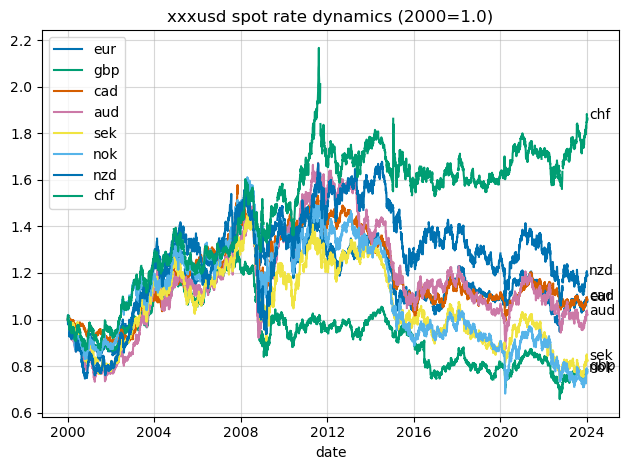

In [18]:
# get spot rates
s = get_usd_exchange_rates()

# calculate appreciation rates
ds = s.ffill().pct_change(fill_method=None).replace(0.0, np.nan).mul(100)\
    .round(4)

# visualize spot
fig, ax = plt.subplots()
s.div(s.iloc[0]).plot(ax=ax)
for _c, _v in s.iloc[-1].div(s.iloc[0]).items():
    ax.annotate(text=_c, xy=(s.index[-1]+DateOffset(months=1), _v))
ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1]+100))
ax.grid(alpha=0.5)
plt.xticks(rotation=0, horizontalalignment="center")
ax.set_title("xxxusd spot rate dynamics (2000=1.0)")
fig.tight_layout()

Next, we calculate the number of business days to the next announcement by the 'own' central bank and the FOMC.

In [19]:
b2c = get_bank_to_currency_map()

# need to introduce something for the fomc 'fx'
ds["usd"] = np.nan

res = {}

for _b, _c in b2c.set_index("bank")["currency"].items():
    # merge on spot return date = date of the next announcement
    mrg = pd.merge_asof(
        ds[_c].rename("fx_return").reset_index(),
        pr.query(f"bank == '{_b}'"),
        left_on="date", right_on="date_announcement",
        direction="forward"
    )

    # remove days w/o announcement scheduled (like the last ones)
    mrg = mrg.dropna(subset="date_announcement")

    # calculate number of business days from a date to the announcement date
    mrg.loc[:, "n_days"] = -1*np.busday_count(
            mrg["date"].dt.date.values.astype('datetime64[D]'),
            mrg["date_announcement"].dt.date.values.astype('datetime64[D]')
    )
    mrg["direction"] = np.sign(mrg["rate_change"]).map(
        {1.0: "hike", 0.0: "no_change", -1.0: "cut"}
    )

    res[_c] = mrg\
        .loc[:, ["date", "date_announcement", "n_days", "fx_return",
                    "direction", "is_scheduled"]]\
        .query("(n_days > -11) & (n_days < 0)")

res = pd.concat(res, names=["currency"])\
    .reset_index(level="currency")\
    .reset_index(drop=True)
res["n_days"] = res["n_days"].astype(int)

# add fomc
res = pd.merge(
    res.query("currency != 'usd'"),
    res.query("currency == 'usd'").drop(["currency", "fx_return"], axis=1),
    on="date", suffixes=["_own", "_fomc"]
)

Let's save the merged data to a .csv file.

In [20]:
res.to_csv("../data/processed/data.csv", index=False)